<a href="https://colab.research.google.com/github/toneswest/Telco-Churn-Project/blob/master/Telco_Retention_Analysis_Oct_8_AW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load data & Import libraries

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.facecolor'] = 'w'

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:

telco_url = '/content/drive/My Drive/1000mL/Telco Churn/Telco-Customer-Churn.csv'


In [0]:
telco_df = pd.read_csv(telco_url)

telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA

## Check datatypes, shapes, nulls

In [0]:
telco_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [0]:
telco_df.notnull().sum()

customerID          7043
gender              7043
SeniorCitizen       7043
Partner             7043
Dependents          7043
tenure              7043
PhoneService        7043
MultipleLines       7043
InternetService     7043
OnlineSecurity      7043
OnlineBackup        7043
DeviceProtection    7043
TechSupport         7043
StreamingTV         7043
StreamingMovies     7043
Contract            7043
PaperlessBilling    7043
PaymentMethod       7043
MonthlyCharges      7043
TotalCharges        7043
Churn               7043
dtype: int64

In [0]:
telco_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### investigate/fix total charges

In [0]:
pd.to_numeric(telco_df.TotalCharges)

ValueError: ignored

This isn't letting me convert to numeric b/c there are string values at row 488... let's investigate 

In [0]:
telco_df.TotalCharges[485:490]

485    6130.85
486       1415
487    6201.95
488           
489      74.35
Name: TotalCharges, dtype: object

In [0]:
telco_df.loc[telco_df.TotalCharges == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


I see total charges is just monthly times tenure. And these blanks all have zero tenure. So let's see if they're the only ones.

In [0]:
telco_df.loc[telco_df.tenure == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Yup, so we'll impute a zero for those blanks and be done with it.

In [0]:
telco_df.loc[telco_df.tenure == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [0]:
telco_df.TotalCharges = pd.to_numeric(telco_df.TotalCharges)

In [0]:
telco_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Whammo.

In [0]:
telco_df.TotalCharges.replace(' ', 0, inplace=True)

## Explore distributions etc.

In [0]:
categorical_variables = [ 'gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

numerical_variables = ['MonthlyCharges', 'tenure']

target_variable = 'Churn'

In [0]:
print(categorical_variables)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [0]:
telco_df.shape

(7043, 21)

In [0]:
telco_df.columns


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [0]:
telco_df['customerID'].nunique()

7043

In [0]:
telco_df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [0]:
telco_df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [0]:
#Create a for-loop to run some standard EDA on categorical variables.

for column in categorical_variables:
  print(f'{telco_df[column].value_counts()} {telco_df[column].value_counts(normalize = True)}')

NameError: ignored

In [0]:
#Created for loop to run basic EDA on numerical variables - describe
for col in numerical_variables:
  print(telco_df[col].describe().round())

count    7043.0
mean       32.0
std        25.0
min         0.0
25%         9.0
50%        29.0
75%        55.0
max        72.0
Name: tenure, dtype: float64
count    7043.0
mean       65.0
std        30.0
min        18.0
25%        36.0
50%        70.0
75%        90.0
max       119.0
Name: MonthlyCharges, dtype: float64
count    7043.0
mean     2280.0
std      2267.0
min         0.0
25%       399.0
50%      1395.0
75%      3787.0
max      8685.0
Name: TotalCharges, dtype: float64


Looking for outliers, don't see any

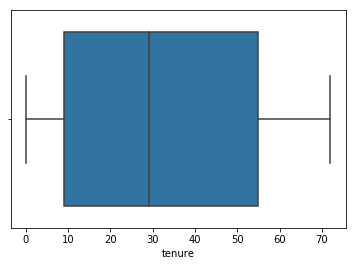

In [0]:
sns.boxplot(telco_df.tenure)


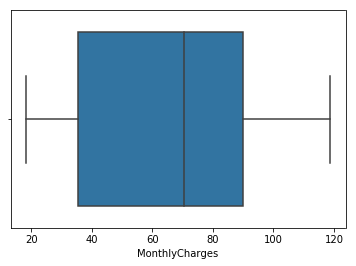

In [0]:
sns.boxplot(telco_df.MonthlyCharges)

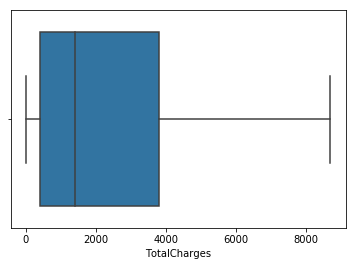

In [0]:
sns.boxplot(telco_df.TotalCharges)

## Create dummy variables

In [0]:
telco_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [0]:
pd.get_dummies(telco_df[['gender','Partner', 'Dependents','PhoneService', 'PaperlessBilling']], drop_first = True).head()

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes
0,0,1,0,0,1
1,1,0,0,1,0
2,1,0,0,1,1
3,1,0,0,0,0
4,0,0,0,1,1


In [0]:
telco_df_2 = telco_df.join(pd.get_dummies(telco_df[['gender',
                                                    'Partner',
                                                    'Dependents',
                                                    'PhoneService', 
                                                    'PaperlessBilling']], drop_first = True))

In [0]:
telco_df_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,PhoneService_Yes,PaperlessBilling_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,1,0,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1,0,1,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,0,1,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,1,1


In [0]:
telco_df_2 = telco_df_2.drop(columns = ['DSL','Fiber optic', 'No'])

KeyError: ignored

In [0]:
#create ordinal variable using .map() for Multiplelines
#example code: s.map({'cat': 'kitten', 'dog': 'puppy'})

telco_df_2['MultipleLines_Yes'] = telco_df_2.MultipleLines.map({'No' : 0,
                            'Yes' : 1,
                           'No phone service':0})

In [0]:
telco_df_2[['InternetService_DSL_Yes','InternetService_Fiber_Yes', 'InternetService_No']] = pd.get_dummies(telco_df['InternetService'])

In [0]:
telco_df_2['OnlineSecurity_Yes'] = telco_df.OnlineSecurity.map({'No' : 0,
                            'Yes' : 1,
                           'No internet service':0})
telco_df_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,1,0,0,1,0,1,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1,0,0,1,0,0,1,0,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,0,0,1,1,0,1,0,0,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,0,0,0,0,1,0,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,0,1,1,0,0,1,0,0


In [0]:
#Should have used a for-loop to create these dummy variables w/ s.map() method.

telco_df_2['OnlineBackup_Yes'] = telco_df.OnlineBackup.map({'No' : 0,
                            'Yes' : 1,
                           'No internet service':0})

telco_df_2['DeviceProtection_Yes'] = telco_df.DeviceProtection.map({'No' : 0,
                            'Yes' : 1,
                           'No internet service':0})

telco_df_2['TechSupport_Yes'] = telco_df.TechSupport.map({'No' : 0,
                            'Yes' : 1,
                           'No internet service':0})


telco_df_2['StreamingTV_Yes'] = telco_df.StreamingTV.map({'No' : 0,
                            'Yes' : 1,
                           'No internet service':0})

telco_df_2['StreamingMovies_Yes'] = telco_df.StreamingMovies.map({'No' : 0,
                            'Yes' : 1,
                           'No internet service':0})

telco_df_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0


In [0]:
telco_df_2.loc[:,'gender_Male':].sum()

gender_Male                  3555
Partner_Yes                  3402
Dependents_Yes               2110
PhoneService_Yes             6361
PaperlessBilling_Yes         4171
MultipleLines_Yes            2971
InternetService_DSL_Yes      2421
InternetService_Fiber_Yes    3096
InternetService_No           1526
OnlineSecurity_Yes           2019
OnlineBackup_Yes             2429
DeviceProtection_Yes         2422
TechSupport_Yes              2044
StreamingTV_Yes              2707
StreamingMovies_Yes          2732
dtype: int64

In [0]:
telco_df_2[['Contract_Monthly_Yes','Contract_1y_Yes', 'Contract_2y_Yes']] = pd.get_dummies(telco_df['Contract'])

In [0]:
telco_df_2['PaperlessBilling_Yes'] = pd.get_dummies(telco_df['PaperlessBilling'], drop_first = True)

In [0]:
telco_df_2 = telco_df_2.join(pd.get_dummies(telco_df['PaymentMethod']))

In [0]:
telco_df_2['Churn_Yes'] = pd.get_dummies(telco_df_2['Churn'], drop_first = True)

In [0]:
telco_df_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_1y_Yes,Contract_2y_Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Churn_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [0]:
telco_df_2.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'InternetService_No', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Monthly_Yes',
       'Contract_1y_Yes', 'Contract_2y_Yes', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check',
       'Churn_Yes'],
      dtype='object')

In [0]:
drop_list = ['gender', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn']

In [0]:
telco_df_2 = telco_df_2.drop(columns = drop_list)

In [0]:
telco_df_2.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_1y_Yes,Contract_2y_Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Churn_Yes,Contract_Type
0,0,1,29.85,29.85,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
2,0,2,53.85,108.15,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0
3,0,45,42.30,1840.75,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1
4,0,2,70.70,151.65,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


In [0]:
telco_df_2.shape

(7043, 27)

In [0]:
#Create ordinal variable for contract_type
contract_dict = {'Month-to-month': 0,
                'One year':1,
                'Two year':2}
telco_df_2['Contract_Type'] = telco_df['Contract'].map(contract_dict)

In [0]:
telco_df_2 = telco_df_2.drop(columns = ['customerID'])

In [0]:
telco_df_2['Product_Count'] = telco_df_2['PhoneService_Yes'] + telco_df_2['MultipleLines_Yes'] + telco_df_2['InternetService_DSL_Yes'] + telco_df_2['InternetService_Fiber_Yes'] + telco_df_2['OnlineSecurity_Yes'] + telco_df_2['OnlineBackup_Yes'] + telco_df_2['DeviceProtection_Yes'] + telco_df_2['StreamingTV_Yes'] + telco_df_2['StreamingMovies_Yes'] 

## Correlation matrix - looking for multi-collinearity

In [0]:
telco_df_2.dtypes

customerID                    object
SeniorCitizen                  int64
tenure                         int64
MonthlyCharges               float64
TotalCharges                 float64
gender_Male                    uint8
Partner_Yes                    uint8
PhoneService_Yes               uint8
PaperlessBilling_Yes           uint8
MultipleLines_Yes              int64
InternetService_DSL_Yes        uint8
InternetService_Fiber_Yes      uint8
InternetService_No             uint8
OnlineSecurity_Yes             int64
OnlineBackup_Yes               int64
DeviceProtection_Yes           int64
TechSupport_Yes                int64
StreamingTV_Yes                int64
StreamingMovies_Yes            int64
Contract_Monthly_Yes           uint8
Contract_1y_Yes                uint8
Contract_2y_Yes                uint8
Bank transfer (automatic)      uint8
Credit card (automatic)        uint8
Electronic check               uint8
Mailed check                   uint8
Churn_Yes                      uint8
d

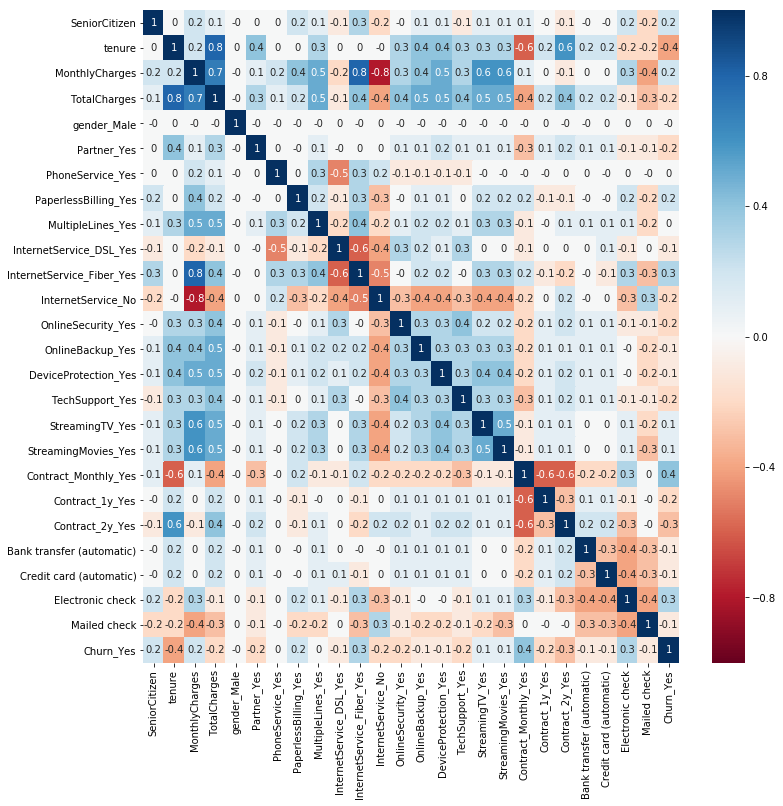

In [0]:
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(telco_df_2.corr().round(1), vmin = -1, vmax = 1, cmap = 'RdBu', annot = True, ax=ax)


POsitively correlated w/ churn:
* senior (seniors more likely to churn)
* monthly charges(increase together)
* paperless
* fiber internet
* monthly contract
* electronic check

Negatively correlated
* tenure (as this decreases, churn risk increases)
* total charges (related to tenure)
* contract 1-2years (less likely to churn)
* partner 
* tech support

## Attempt at cross-tabs for churn Y/N

Documentation:

`crosstab(index, columns, values=None, rownames=None, colnames=None, aggfunc=None, margins=False, margins_name='All', dropna=True, normalize=False)¶`

In [0]:
senior_churn_df = pd.crosstab(columns = telco_df.Churn, index = telco_df.SeniorCitizen, normalize = 'index')
senior_churn_df

Churn,No,Yes
SeniorCitizen,,
0,0.763938,0.236062
1,0.583187,0.416813


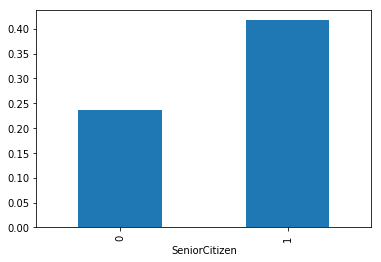

In [0]:
senior_churn_df.loc[:,'Yes'].plot(kind='bar')

In [0]:
senior_churn_df.columns

Index(['No', 'Yes'], dtype='object', name='Churn')

In [0]:
#don't need this part, but important learning re. division 'by element' for this method.
senior_churn_df.div(senior_churn_df.sum(axis=1), axis=0)

Churn,No,Yes
SeniorCitizen,,
0,0.763938,0.236062
1,0.583187,0.416813


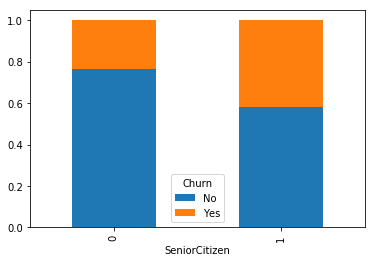

In [0]:

senior_churn_df.plot(kind='bar', stacked = True)


#Modelling... start with logistic regression...

Which variables need to be scaled?
* tenure
* MonthlyCharges
* TotalCharges

##Steps:
1. Build column transformer (to scale numerical variables)
  * standard scaler
2. Build pipeline w/ Column Transformer and Model
3. Grid Search (includes model params to tune and cross validation)
    * Model variations:
      * class_weight = balanced vs. non (we'll use balanced as dataset is imbalanced)
      * penalty (L1, L2, elasticnet, none)
      * C (when penalty is none)
      * Solver - always test solver w/ one fitting instance before using to cross validate...?
      * L1 ratio (only for elasticnet)

### Basic Logistic Model

1. Set variables
2. Train test split
3. Scale data
4. Fit model

### MOdel 1 - logistic, scaled, unbalanced, all variables

In [0]:
telco_df_2.columns

Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'InternetService_No', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Monthly_Yes',
       'Contract_1y_Yes', 'Contract_2y_Yes', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check',
       'Churn_Yes'],
      dtype='object')

In [0]:
#set variables
X1 = telco_df_2[['SeniorCitizen', 'tenure', 'MonthlyCharges',
                 'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'InternetService_No', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Monthly_Yes',
       'Contract_1y_Yes', 'Contract_2y_Yes', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check']]

y1 = telco_df_2['Churn_Yes']


In [0]:
#train test split
X1_train, X1_val, y1_train, y1_val = train_test_split(X1,y1, test_size = 0.2, random_state = 42)

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
#apply scaler - using column transformer

logreg_transformer = ColumnTransformer(transformers = 
                                      [('scaler', StandardScaler(), numerical_variables)],
                                      remainder = 'passthrough',
                                      verbose = True)

In [0]:
X1_train.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_1y_Yes,Contract_2y_Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
2142,0,21,64.85,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1
1623,0,54,97.20,0,0,1,1,1,0,1,0,0,1,0,0,1,1,0,0,1,1,0,0,0
6074,0,1,23.45,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1362,0,4,70.20,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6754,0,0,61.90,1,0,1,1,1,1,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0


In [0]:
#fit the transformer to the training data
logreg_transformer.fit(X1_train)


[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('scaler',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['tenure', 'MonthlyCharges'])],
                  verbose=True)

In [0]:
#tranform training and validation data
X1_train_transform = logreg_transformer.transform(X1_train)
X1_val_transform = logreg_transformer.transform(X1_val)

In [0]:
#set model object and fit
logreg_model_1 = LogisticRegression(penalty = 'none', solver = 'lbfgs', class_weight='balanced')

logreg_model_1.fit(X1_train_transform, y1_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [0]:
confusion_matrix(y1_train, logreg_model_1.predict(X1_train_transform))

array([[3022, 1116],
       [ 310, 1186]])

In [0]:
print(accuracy_score(y1_train, logreg_model_1.predict(X1_train_transform)))
print(accuracy_score(y1_val, logreg_model_1.predict(X1_val_transform)))

0.746893858714945
0.7544357700496807


In [0]:
print(recall_score(y1_train, logreg_model_1.predict(X1_train_transform)))
print(recall_score(y1_val, logreg_model_1.predict(X1_val_transform)))

0.7927807486631016
0.8230563002680965


In [0]:
len(logreg_model_1.coef_[0])

24

#### coefs

In [0]:
pd.Series(logreg_model_1.coef_[0], index = X1_train.columns)

SeniorCitizen               -0.750413
tenure                      -1.685356
MonthlyCharges               0.189814
gender_Male                 -0.033726
Partner_Yes                 -0.027624
PhoneService_Yes             0.674501
PaperlessBilling_Yes         0.308307
MultipleLines_Yes            0.534530
InternetService_DSL_Yes     -0.575837
InternetService_Fiber_Yes    1.698487
InternetService_No          -2.772570
OnlineSecurity_Yes          -0.115322
OnlineBackup_Yes             0.156938
DeviceProtection_Yes         0.270274
TechSupport_Yes             -0.016648
StreamingTV_Yes              0.810446
StreamingMovies_Yes          0.921920
Contract_Monthly_Yes         0.190678
Contract_1y_Yes             -0.506544
Contract_2y_Yes             -1.334055
Bank transfer (automatic)   -0.484762
Credit card (automatic)     -0.551686
Electronic check            -0.135822
Mailed check                -0.477650
dtype: float64

### Model2 - natalie's model


In [0]:
telco_df_2.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_1y_Yes,Contract_2y_Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Churn_Yes,Contract_Type
0,0,1,29.85,29.85,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0,34,56.95,1889.50,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0
3,0,45,42.30,1840.75,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1
4,0,2,70.70,151.65,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


In [0]:
numerical_variables_2 = ['MonthlyCharges','tenure']

categorical_variables_2 = ['SeniorCitizen', 'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Type', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check']

In [0]:
#set variables
X2 = telco_df_2[numerical_variables_2 + categorical_variables_2]

y2 = telco_df_2['Churn_Yes']

In [0]:
X2.columns

Index(['MonthlyCharges', 'tenure', 'SeniorCitizen', 'gender_Male',
       'Partner_Yes', 'PhoneService_Yes', 'PaperlessBilling_Yes',
       'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_Type', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check'],
      dtype='object')

In [0]:
#train test split
X2_train, X2_val, y2_train, y2_val = train_test_split(X2,y2, test_size = 0.2, random_state = 42)

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
#apply scaler - using column transformer

logreg_transformer = ColumnTransformer(transformers = 
                                      [('scaler', StandardScaler(), numerical_variables)],
                                      remainder = 'passthrough',
                                      verbose = True)

In [0]:
X2_train.head()

,MonthlyCharges,tenure,SeniorCitizen,gender_Male,Partner_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
2142,64.85,21,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1
1623,97.20,54,0,0,0,1,1,1,0,1,0,1,0,0,1,1,2,1,0,0,0
6074,23.45,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1362,70.20,4,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
6754,61.90,0,0,1,0,1,1,1,1,0,1,1,0,1,0,0,2,1,0,0,0


In [0]:
#fit the transformer to the training data
logreg_transformer.fit(X2_train)


[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('scaler',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['MonthlyCharges', 'tenure'])],
                  verbose=True)

In [0]:
#tranform training and validation data
X2_train_transform = logreg_transformer.transform(X2_train)
X2_val_transform = logreg_transformer.transform(X2_val)

In [0]:
#set model object and fit
logreg_model_2 = LogisticRegression(penalty = 'none', solver = 'lbfgs', class_weight='balanced')

logreg_model_2.fit(X2_train_transform, y2_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [0]:
confusion_matrix(y2_train, logreg_model_2.predict(X2_train_transform))

array([[3024, 1114],
       [ 310, 1186]])

In [0]:
print(accuracy_score(y2_train, logreg_model_2.predict(X2_train_transform)))
print(accuracy_score(y2_val, logreg_model_2.predict(X2_val_transform)))

0.7472488462903798
0.7579843860894251


In [0]:
print(recall_score(y2_train, logreg_model_2.predict(X2_train_transform)))
print(recall_score(y2_val, logreg_model_2.predict(X2_val_transform)))

0.7927807486631016
0.8230563002680965


In [0]:
len(logreg_model_2.coef_[0])

21

#### coefs

In [0]:
pd.Series(logreg_model_2.coef_[0], index = X2_train.columns)

MonthlyCharges              -1.682101
tenure                      -0.747514
SeniorCitizen                0.189956
gender_Male                 -0.033245
Partner_Yes                 -0.027094
PhoneService_Yes             0.674989
PaperlessBilling_Yes         0.307661
MultipleLines_Yes            0.531678
InternetService_DSL_Yes      2.193961
InternetService_Fiber_Yes    4.463223
OnlineSecurity_Yes          -0.115616
OnlineBackup_Yes             0.156547
DeviceProtection_Yes         0.271079
TechSupport_Yes             -0.017379
StreamingTV_Yes              0.811580
StreamingMovies_Yes          0.923490
Contract_Type               -0.743098
Bank transfer (automatic)   -0.999204
Credit card (automatic)     -1.065640
Electronic check            -0.650320
Mailed check                -0.991250
dtype: float64

In [0]:
X2_train.describe()

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
count,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000
mean,0.160809,32.373092,64.864253,0.512425,0.484558,0.902023,0.590167,0.425453,0.344160,0.440362,0.285765,0.350018,0.342741,0.289137,0.387114,0.389954,0.690451,0.219737,0.217785,0.334931,0.227547
std,0.367388,24.424539,30.089324,0.499890,0.499806,0.297309,0.491846,0.494455,0.475136,0.496475,0.451818,0.477018,0.474668,0.453402,0.487133,0.487783,0.830168,0.414105,0.412777,0.472008,0.419286
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.750000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.525000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,55.000000,89.937500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,118.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
telco_df_2.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_1y_Yes,Contract_2y_Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Churn_Yes,Contract_Type
0,0,1,29.85,29.85,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0,34,56.95,1889.50,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0
3,0,45,42.30,1840.75,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1
4,0,2,70.70,151.65,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


### Additional exploration

In [0]:
telco_df_2.loc[telco_df_2['Churn_Yes'] == 1]['MonthlyCharges']

In [0]:
import random
import numpy
from matplotlib import pyplot

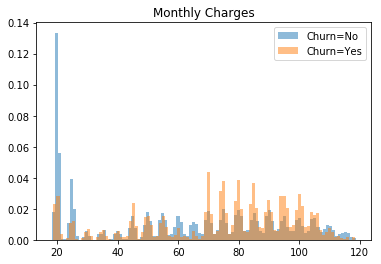

In [0]:


pyplot.hist((telco_df_2.loc[telco_df_2['Churn_Yes'] == 0]['MonthlyCharges']), alpha = 0.5, density=True, bins=100, label='Churn=No')
pyplot.hist((telco_df_2.loc[telco_df_2['Churn_Yes'] == 1]['MonthlyCharges']), alpha = 0.5, density=True, bins = 100, label='Churn=Yes')

pyplot.legend(loc='upper right')
pyplot.title('Monthly Charges')
pyplot.show()


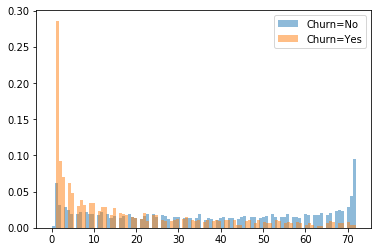

In [0]:
pyplot.hist((telco_df_2.loc[telco_df_2['Churn_Yes'] == 0]['tenure']), alpha = 0.5, density=True, bins=100, label='Churn=No')
pyplot.hist((telco_df_2.loc[telco_df_2['Churn_Yes'] == 1]['tenure']), alpha = 0.5, density=True, bins = 100, label='Churn=Yes')

pyplot.legend(loc='upper right')
pyplot.show()

In [0]:
senior_churn_df = pd.crosstab(columns = telco_df.Churn, index = telco_df.SeniorCitizen, normalize = 'index')
senior_churn_df

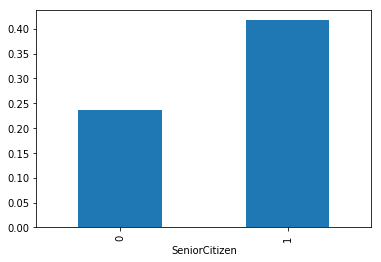

In [0]:
senior_churn_df.loc[:,'Yes'].plot(kind='bar')

In [0]:
telco_df_2.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'InternetService_No', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Monthly_Yes',
       'Contract_1y_Yes', 'Contract_2y_Yes', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check',
       'Churn_Yes', 'Contract_Type'],
      dtype='object')

In [0]:
partner_churn_df = pd.crosstab(columns = telco_df_2.Churn_Yes, index = telco_df_2.Partner_Yes)
partner_churn_df

Churn_Yes,0,1
Partner_Yes,,
0,2441,1200
1,2733,669


In [0]:
partner_churn_df = pd.crosstab(columns = telco_df_2.Churn_Yes, index = telco_df_2.Partner_Yes, normalize = 'index')
partner_churn_df

Churn_Yes,0,1
Partner_Yes,,
0,0.670420,0.329580
1,0.803351,0.196649


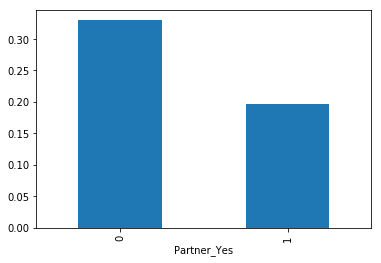

In [0]:
partner_churn_df.loc[:,1].plot(kind='bar')

In [0]:
phone_churn_df = pd.crosstab(columns = telco_df_2.Churn_Yes, index = telco_df_2['PhoneService_Yes'], normalize = 'index')
phone_churn_df

Churn_Yes,0,1
PhoneService_Yes,,
0,0.750733,0.249267
1,0.732904,0.267096


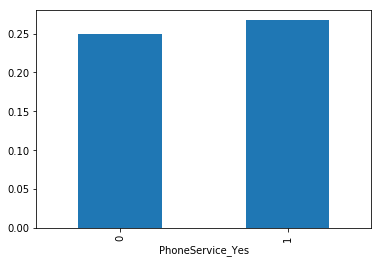

In [0]:
phone_churn_df.loc[:,1].plot(kind='bar')

In [0]:
telco_df_2.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'InternetService_No', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Monthly_Yes',
       'Contract_1y_Yes', 'Contract_2y_Yes', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check',
       'Churn_Yes', 'Contract_Type', 'Product_Count'],
      dtype='object')

In [0]:
telco_df_2['Product_Count'] = telco_df_2['PhoneService_Yes'] + telco_df_2['MultipleLines_Yes'] + telco_df_2['InternetService_DSL_Yes'] + telco_df_2['InternetService_Fiber_Yes'] + telco_df_2['OnlineSecurity_Yes'] + telco_df_2['OnlineBackup_Yes'] + telco_df_2['DeviceProtection_Yes'] + telco_df_2['StreamingTV_Yes'] + telco_df_2['StreamingMovies_Yes'] 

In [0]:
telco_df_2['Product_Count'].value_counts()

1    1285
4    1079
5    1009
3     953
2     949
6     892
7     605
8     271
Name: Product_Count, dtype: int64

In [0]:
ProductCount_churn_df = pd.crosstab(columns = telco_df_2.Churn_Yes, index = telco_df_2['Product_Count'], normalize = 'index')
ProductCount_churn_df

Churn_Yes,0,1
Product_Count,,
1,0.887938,0.112062
2,0.703899,0.296101
3,0.575026,0.424974
4,0.661724,0.338276
5,0.705649,0.294351
6,0.748879,0.251121
7,0.778512,0.221488
8,0.929889,0.070111


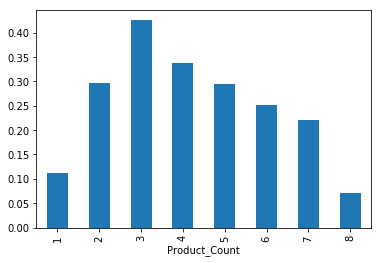

In [0]:
ProductCount_churn_df.loc[:,1].plot(kind='bar')

### Model 3 - ‘liblinear', unscaled

In [0]:
numerical_variables_3 = ['MonthlyCharges','tenure']

categorical_variables_3 = ['SeniorCitizen', 'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Type', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check']

In [0]:
#set variables
X3 = telco_df_2[numerical_variables_2 + categorical_variables_2]

y3 = telco_df_2['Churn_Yes']

In [0]:
#train test split
X3_train, X3_val, y3_train, y3_val = train_test_split(X3,y3, test_size = 0.2, random_state = 42)

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
#set model object and fit
logreg_model_3 = LogisticRegression(penalty = 'none', solver = 'lbfgs', class_weight='balanced')

logreg_model_3.fit(X3_train, y3_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [0]:
confusion_matrix(y3_train, logreg_model_3.predict(X3_train))

array([[3027, 1111],
       [ 308, 1188]])

In [0]:
print(accuracy_score(y3_train, logreg_model_2.predict(X3_train)))
print(accuracy_score(y3_val, logreg_model_2.predict(X3_val)))

0.7344692935747249
0.7352732434350603


In [0]:
print(recall_score(y3_train, logreg_model_3.predict(X3_train)))
print(recall_score(y3_val, logreg_model_3.predict(X3_val)))

0.7941176470588235
0.8310991957104558


#### coefs

In [0]:
pd.Series(logreg_model_3.coef_[0], index = X3_train.columns)

MonthlyCharges               0.025093
tenure                      -0.030382
SeniorCitizen                0.182922
gender_Male                 -0.029748
Partner_Yes                 -0.026675
PhoneService_Yes            -0.914880
PaperlessBilling_Yes         0.319631
MultipleLines_Yes            0.119366
InternetService_DSL_Yes      0.190456
InternetService_Fiber_Yes    0.434226
OnlineSecurity_Yes          -0.520873
OnlineBackup_Yes            -0.248478
DeviceProtection_Yes        -0.129401
TechSupport_Yes             -0.428530
StreamingTV_Yes             -0.005664
StreamingMovies_Yes          0.112115
Contract_Type               -0.738784
Bank transfer (automatic)   -0.083265
Credit card (automatic)     -0.151308
Electronic check             0.256765
Mailed check                -0.076784
dtype: float64

### Model 4 - MinMax Scaler

In [0]:
numerical_variables_4 = ['MonthlyCharges','tenure']

categorical_variables_4 = ['SeniorCitizen', 'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Type', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check']

In [0]:
#set variables
X4 = telco_df_2[numerical_variables_4 + categorical_variables_4]

y4 = telco_df_2['Churn_Yes']

In [0]:
#train test split
X4_train, X4_val, y4_train, y4_val = train_test_split(X4,y4, test_size = 0.2, random_state = 42)

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
#apply scaler - using column transformer

logreg_transformer = ColumnTransformer(transformers = 
                                      [('scaler', MinMaxScaler(), numerical_variables)],
                                      remainder = 'passthrough',
                                      verbose = True)

In [0]:
#fit the transformer to the training data
logreg_transformer.fit(X4_train)


[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('scaler',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['MonthlyCharges', 'tenure'])],
                  verbose=True)

In [0]:
#tranform training and validation data
X4_train_transform = logreg_transformer.transform(X4_train)
X4_val_transform = logreg_transformer.transform(X4_val)

In [0]:
#set model object and fit
logreg_model_4 = LogisticRegression(penalty = 'none', solver = 'lbfgs', class_weight='balanced')

logreg_model_4.fit(X4_train_transform, y4_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [0]:
confusion_matrix(y4_train, logreg_model_4.predict(X4_train_transform))

array([[3024, 1114],
       [ 310, 1186]])

In [0]:
print(accuracy_score(y4_train, logreg_model_4.predict(X4_train_transform)))
print(accuracy_score(y4_val, logreg_model_4.predict(X4_val_transform)))

0.7472488462903798
0.7579843860894251


In [0]:
print(recall_score(y4_train, logreg_model_4.predict(X4_train_transform)))
print(recall_score(y4_val, logreg_model_4.predict(X4_val_transform)))

0.7927807486631016
0.8230563002680965


#### coefs

In [0]:
pd.Series(logreg_model_4.coef_[0], index = X4_train.columns)

MonthlyCharges              -5.608161
tenure                      -2.203074
SeniorCitizen                0.189969
gender_Male                 -0.033253
Partner_Yes                 -0.027147
PhoneService_Yes             0.674646
PaperlessBilling_Yes         0.307619
MultipleLines_Yes            0.531503
InternetService_DSL_Yes      2.193469
InternetService_Fiber_Yes    4.462113
OnlineSecurity_Yes          -0.115712
OnlineBackup_Yes             0.156452
DeviceProtection_Yes         0.270957
TechSupport_Yes             -0.017496
StreamingTV_Yes              0.811178
StreamingMovies_Yes          0.923345
Contract_Type               -0.743265
Bank transfer (automatic)   -0.279823
Credit card (automatic)     -0.346237
Electronic check             0.069116
Mailed check                -0.271683
dtype: float64

### Model 5 - MinMax scaling everything


In [0]:
numerical_variables_5 = ['MonthlyCharges','tenure']

categorical_variables_5 = ['SeniorCitizen', 'gender_Male', 'Partner_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'MultipleLines_Yes', 'InternetService_DSL_Yes',
       'InternetService_Fiber_Yes', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Type', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check']

In [0]:
#set variables
X5 = telco_df_2[numerical_variables_5 + categorical_variables_5]

y5 = telco_df_2['Churn_Yes']

In [0]:
#train test split
X5_train, X5_val, y5_train, y5_val = train_test_split(X5,y5, test_size = 0.2, random_state = 42)

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
#apply scaler - using column transformer - applied to all columns

logreg_transformer = MinMaxScaler()

In [0]:
#fit the transformer to the training data
logreg_transformer.fit(X5_train)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
#tranform training and validation data
X5_train_transform = logreg_transformer.transform(X5_train)
X5_val_transform = logreg_transformer.transform(X5_val)

In [0]:
#set model object and fit
logreg_model_5 = LogisticRegression(penalty = 'none', solver = 'lbfgs', class_weight='balanced')

logreg_model_5.fit(X5_train_transform, y5_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [0]:
confusion_matrix(y5_train, logreg_model_5.predict(X5_train_transform))

array([[3024, 1114],
       [ 310, 1186]])

In [0]:
print(accuracy_score(y5_train, logreg_model_5.predict(X5_train_transform)))
print(accuracy_score(y5_val, logreg_model_5.predict(X5_val_transform)))

0.7472488462903798
0.7579843860894251


In [0]:
print(recall_score(y5_train, logreg_model_5.predict(X5_train_transform)))
print(recall_score(y5_val, logreg_model_5.predict(X5_val_transform)))

0.7927807486631016
0.8230563002680965


#### coefs

In [0]:
pd.Series(logreg_model_5.coef_[0], index = X5_train.columns)

MonthlyCharges              -5.609049
tenure                      -2.203539
SeniorCitizen                0.189900
gender_Male                 -0.033250
Partner_Yes                 -0.027107
PhoneService_Yes             0.674566
PaperlessBilling_Yes         0.307621
MultipleLines_Yes            0.531596
InternetService_DSL_Yes      2.193871
InternetService_Fiber_Yes    4.462834
OnlineSecurity_Yes          -0.115668
OnlineBackup_Yes             0.156475
DeviceProtection_Yes         0.270980
TechSupport_Yes             -0.017468
StreamingTV_Yes              0.811225
StreamingMovies_Yes          0.923424
Contract_Type               -1.486191
Bank transfer (automatic)   -0.279813
Credit card (automatic)     -0.346197
Electronic check             0.069055
Mailed check                -0.271690
dtype: float64

### Model 6 - product count - standard scalered - FINAL MODEL


In [0]:
numerical_variables_6 = ['MonthlyCharges','tenure', 'Product_Count']

categorical_variables_6 = ['SeniorCitizen',  'Dependents_Yes',
                           'Contract_Type', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check']

In [0]:
#set variables
X6 = telco_df_2[numerical_variables_6 + categorical_variables_6]

y6 = telco_df_2['Churn_Yes']

In [0]:
#train test split
X6_train, X6_val, y6_train, y6_val = train_test_split(X6,y6, test_size = 0.2, random_state = 42)

In [0]:
X6_train.shape

(5634, 10)

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
#apply scaler - using column transformer

logreg_transformer = ColumnTransformer(transformers = 
                                      [('scaler', StandardScaler(), numerical_variables_6)],
                                      remainder = 'passthrough',
                                      verbose = True)

In [0]:
#fit the transformer to the training data
logreg_transformer.fit(X6_train)


[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('scaler',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['MonthlyCharges', 'tenure',
                                  'Product_Count'])],
                  verbose=True)

In [0]:
#tranform training and validation data
X6_train_transform = logreg_transformer.transform(X6_train)
X6_val_transform = logreg_transformer.transform(X6_val)

In [0]:
#set model object and fit
logreg_model_6 = LogisticRegression(penalty = 'none', solver = 'lbfgs', class_weight='balanced')

logreg_model_6.fit(X6_train_transform, y6_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [0]:
confusion_matrix = confusion_matrix(y6_val, logreg_model_6.predict(X6_val_transform))
confusion_matrix

array([[741, 295],
       [ 61, 312]])

Text(0.5, 15.0, 'Predicted label')

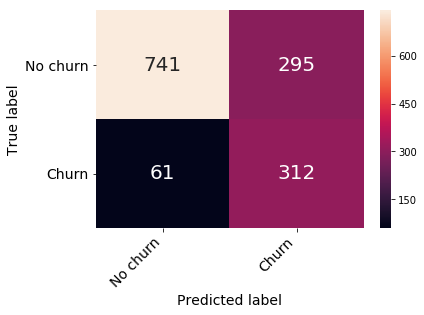

In [0]:
confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No churn', 'Churn'), ('No churn', 'Churn'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

In [0]:
print(accuracy_score(y6_train, logreg_model_6.predict(X6_train_transform)))
print(accuracy_score(y6_val, logreg_model_6.predict(X6_val_transform)))

0.7341143059992901
0.7473385379701917


In [0]:
print(recall_score(y6_train, logreg_model_6.predict(X6_train_transform)))
print(recall_score(y6_val, logreg_model_6.predict(X6_val_transform)))

0.7941176470588235
0.8364611260053619


#### coefs

In [0]:
pd.Series(logreg_model_6.coef_[0], index = X6_train.columns)

MonthlyCharges               0.908164
tenure                      -0.701974
Product_Count               -0.276837
SeniorCitizen                0.288875
Dependents_Yes              -0.209909
Contract_Type               -0.894422
Bank transfer (automatic)   -0.064432
Credit card (automatic)     -0.130947
Electronic check             0.405109
Mailed check                -0.183607
dtype: float64

In [0]:
model_coef_6 = (pd.Series(logreg_model_6.coef_[0], index = X6_train.columns)).sort_values(ascending=False)

In [0]:
model_coef_6

MonthlyCharges               0.908164
Electronic check             0.405109
SeniorCitizen                0.288875
Bank transfer (automatic)   -0.064432
Credit card (automatic)     -0.130947
Mailed check                -0.183607
Dependents_Yes              -0.209909
Product_Count               -0.276837
tenure                      -0.701974
Contract_Type               -0.894422
dtype: float64

#### Graphing results

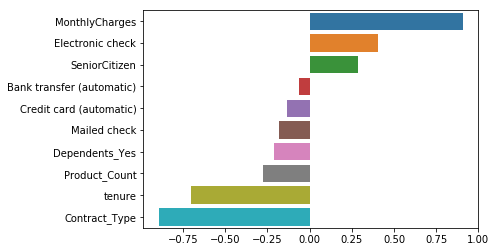

In [0]:
sns.barplot(x = model_coef_6, y = model_coef_6.index)
#plt.xticks(rotation='vertical')

In [0]:
pd.Series(logreg_model_6.predict(X6_val_transform))

# Projecting results to un-churned customer base

original dataset:
* drop non-churners
* drop non-model variables
* run prediction
* add prediction back to data
* divid into quintiles and identify number of high value (80% plus) monthly spend... will save you x dollars over y period...

Does model tell you when they will churn??? No!

In [0]:
telco_df_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_1y_Yes,Contract_2y_Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Churn_Yes,Contract_Type,Product_Count
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,3
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,2


In [0]:
#Extract non-churned customers

telco_active_df = telco_df_2.loc[telco_df_2['Churn'] == 'No']
telco_active_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_1y_Yes,Contract_2y_Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Churn_Yes,Contract_Type,Product_Count
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,3
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No,1,0,1,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,5
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2


In [0]:
telco_active_df.shape

(5174, 46)

In [0]:
numerical_variables_7 = ['MonthlyCharges','tenure', 'Product_Count']

categorical_variables_7 = ['SeniorCitizen',  'Dependents_Yes',
                           'Contract_Type', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check']

In [0]:
#set variables
X7 = telco_active_df[numerical_variables_6 + categorical_variables_6]

y7 = telco_active_df['Churn_Yes']

In [0]:
#no train test split!
#just scale that data with the model 6 scaler, fitted to model6 train data...
X7_transform = logreg_transformer.transform(X7)

In [0]:
X7.shape

(5174, 10)

In [0]:
X7_transform.shape

(5174, 10)

In [0]:
logreg_model_6.predict(X7_transform).shape

(5174,)

In [0]:
logreg_model_6.predict(X7_transform).sum()

1485

In [0]:
#Create a series to slip into df
Churn_Pred_Y_Series = pd.Series(logreg_model_6.predict(X7_transform))

In [0]:
Churn_Pred_Y_Series.value_counts()

0    3689
1    1485
dtype: int64

In [0]:
Churn_Pred_Y_Series

In [0]:
#getting cock-blocked because the dang indexes don't line up.
telco_active_df.index

Int64Index([   0,    1,    3,    6,    7,    9,   10,   11,   12,   14,
            ...
            7030, 7031, 7033, 7035, 7036, 7037, 7038, 7039, 7040, 7042],
           dtype='int64', length=5174)

In [0]:
telco_active_df.reset_index(inplace=True)

In [0]:
telco_active_df.index

RangeIndex(start=0, stop=5174, step=1)

In [0]:
telco_active_df['Churn_Pred_Y'] = pd.DataFrame(Churn_Pred_Y_Series)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
telco_active_df['Churn_Pred_Y'].value_counts()

0    3689
1    1485
Name: Churn_Pred_Y, dtype: int64

In [0]:
telco_active_df['Churn_Pred_Y'].value_counts(normalize = True)

([<matplotlib.axis.XTick at 0x7f8bd2b29860>,
 <a list of 2 Text xticklabel objects>)

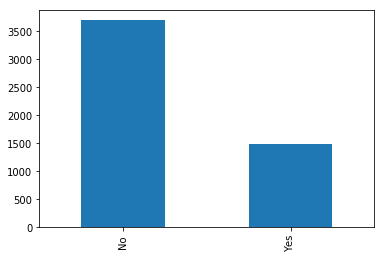

In [0]:
telco_active_df['Churn_Pred_Y'].value_counts().plot(kind='bar', stacked = True)
plt.xticks([0,1],['No','Yes'])

In [0]:
telco_active_df.head()

,index,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_DSL_Yes,InternetService_Fiber_Yes,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_1y_Yes,Contract_2y_Yes,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Churn_Yes,Contract_Type,Product_Count,Churn_Pred_Y
0,0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,2,1
1,1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,4,0
2,3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,3,0
3,6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No,1,0,1,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,5,1
4,7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2,0


In [0]:
#create new df of just predicted churners to analyse
telco_active_churn_df = telco_active_df.loc[telco_active_df['Churn_Pred_Y'] == 1]

In [0]:
telco_active_churn_df.shape

(1485, 48)

In [0]:
(telco_active_churn_df['MonthlyCharges'].sum())*12

1338540.0

In [0]:
telco_active_churn_df['MonthlyCharges'].quantile(q=0.2)

54.49

In [0]:
telco_active_churn_df['MonthlyCharges'].describe()

count    1485.000000
mean       75.114478
std        21.164100
min        18.850000
25%        59.150000
50%        78.100000
75%        91.100000
max       116.500000
Name: MonthlyCharges, dtype: float64

In [0]:
(telco_active_churn_df.loc[telco_active_churn_df['MonthlyCharges'] >= 91]['MonthlyCharges'].sum())*12

452563.80000000005

In [0]:
(telco_active_churn_df.loc[telco_active_churn_df['MonthlyCharges'] < 91]['MonthlyCharges'].sum())*12

885976.2000000001